# Udacity Self-Driving Car
## Vehicle Detection Project

## 0 Library Import

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle
from skimage.feature import hog
import time



%matplotlib inline

We will define a ```read_rgb_img``` function to make sure images' pixel value are in sacle of [0, 256].

In [2]:
def read_rgb_img(img_path):
    if img_path.endswith('.jpg'):
        return mpimg.imread(img_path)
    elif img_path.endswith('.png'):
        img = cv2.imread(img_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise Exception("Image format does not support: {}".format(img_path)) 

## 1 Dataset Exploration

We will explore datasets for training a **binary car classifier**. The data we have are in ```vehicles``` and ```non-vehicles``` folders.

Text(0.5,1,'sample non car image')

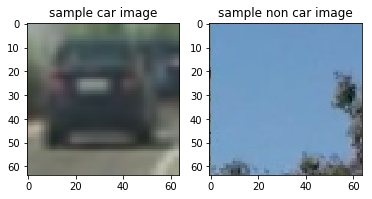

In [3]:
root_vehicles_dir = 'vehicles'
root_non_vehicles_dir = 'non-vehicles'

vehicles_files = glob.glob(root_vehicles_dir + '/*/*.png')
non_vehicles_files = glob.glob(root_non_vehicles_dir + '/*/*.png')


example_vehicle_img = read_rgb_img(vehicles_files[0])
example_non_vehicle_img = read_rgb_img(non_vehicles_files[0])

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(example_vehicle_img)
ax1.set_title('sample car image')

ax2.imshow(example_non_vehicle_img)
ax2.set_title('sample non car image')


## 2 Image features


### Color Histogram

In [4]:
def color_hist(img, nbins = 32, bins_range = (0, 256), visualise = False):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ch1_hist = np.histogram(img[:,:,0], nbins, bins_range)
    ch2_hist = np.histogram(img[:,:,1], nbins, bins_range)
    ch3_hist = np.histogram(img[:,:,2], nbins, bins_range)
    
    bin_centers = (ch1_hist[1][0:-1] + ch1_hist[1][1:])
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    
    if visualise:
        return ch1_hist, ch2_hist, ch3_hist, bin_centers, hist_features
    else:
        return hist_features
    
    

Test on example image.

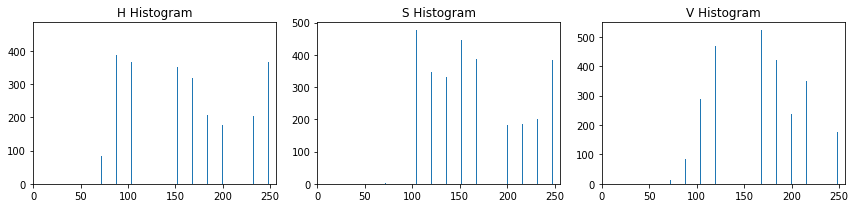

In [5]:
rh, gh, bh, bincen, hist_features = color_hist(example_vehicle_img, visualise = True)

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('H Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('S Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('V Histogram')
fig.tight_layout()

### Spatial Binning of Color



In [6]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

Text(0.5,1,'Spatially Binned Features')

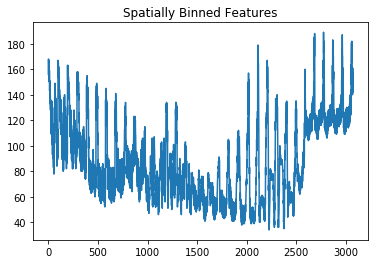

In [7]:
feature_vec = bin_spatial(example_vehicle_img, size=(32, 32))
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

### Gradient Feature: Hog


In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(
                            img, 
                            orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                            cells_per_block=(cell_per_block, cell_per_block), 
                            visualise=True, 
                            feature_vector=False,
                            transform_sqrt = False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(
                img, 
                orientations=orient,
                pixels_per_cell=(pix_per_cell, pix_per_cell), 
                cells_per_block=(cell_per_block, cell_per_block), 
                visualise=False, 
                feature_vector=True,
                transform_sqrt = False)
        return features

/Users/xianlei/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Text(0.5,1,'HOG Visualization')

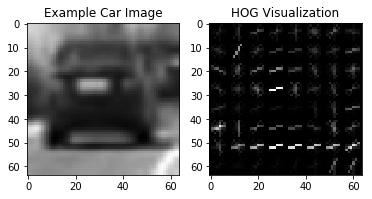

In [9]:
gray = cv2.cvtColor(example_vehicle_img, cv2.COLOR_RGB2GRAY)


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, 
                                       orient = 9, 
                                       pix_per_cell = 8, 
                                       cell_per_block = 2, 
                                       vis=True)

fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


### Combine and Normalize Image features


In [10]:
def extract_features(imgs, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    for img_file in imgs:
        img = read_rgb_img(img_file)

        bin_feature = bin_spatial(img, spatial_size)
        color_feature = color_hist(img, hist_bins, hist_range)
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feature = get_hog_features(gray, 
                                       orient = 9, 
                                       pix_per_cell = 8, 
                                       cell_per_block = 2,
                                       vis=False)
        
        features.append(np.concatenate((bin_feature, color_feature, hog_feature)))
    return features


In [11]:
def normalize_features(X):                      
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    return scaled_X

/Users/xianlei/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature size: 4932


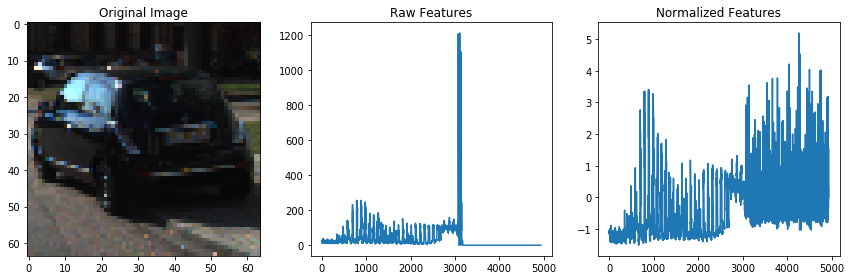

In [12]:
car_features = extract_features(vehicles_files)
notcar_features = extract_features(non_vehicles_files)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
scaled_X = normalize_features(X)
print('Feature size: {}'.format(X.shape[1]))

car_ind = np.random.randint(0, len(car_features))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(read_rgb_img(vehicles_files[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## 3 Training Classifier

### Shuffling training and test data

In [13]:
car_features = np.array(car_features)
notcar_features = np.array(notcar_features)
y_car = np.ones(len(car_features))
y_notcar = np.zeros(len(notcar_features))

X_car_train, X_car_test, y_car_train, y_car_test = train_test_split(car_features, y_car, test_size=0.33, shuffle=True)
X_notcar_train, X_notcar_test, y_notcar_train, y_notcar_test = train_test_split(notcar_features, y_notcar, test_size=0.33, shuffle=True)

X_train = np.vstack((X_car_train, X_notcar_train))
y_train = np.concatenate((y_car_train, y_notcar_train))

X_test = np.vstack((X_car_test, X_notcar_test))
y_test = np.concatenate((y_car_test, y_notcar_test))

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('cars: {}, non cars: {}'.format(
    X_car_train.shape[0], 
    X_notcar_train.shape[0]))


print('X_test shape: {}, y_test shape: {}'.format(X_test.shape, y_test.shape))
print('cars: {}, non cars: {}'.format(
    X_car_test.shape[0], 
    X_notcar_test.shape[0]))



X_train shape: (11898, 4932), y_train shape: (11898,)
cars: 5890, non cars: 6008
X_test shape: (5862, 4932), y_test shape: (5862,)
cars: 2902, non cars: 2960


### Training Model with SVM

In [14]:
parameters = {'kernel': ('linear',), 'C':[1, 10]}
svc = SVC()
svm_clf = GridSearchCV(svc, parameters)

t=time.time()
svm_clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

796.46 Seconds to train SVC...


## Sliding Window